# 경기 지표 정리

| **약어**  | **지표**                          | **설명**                          |
|-----------|-----------------------------------|------------------------------------|
| **GP**    | Games Played                     | 출전 경기 수                      |
| **MIN**   | Minutes Played                   | 경기 시간 (분 단위)               |
| **PTS**   | Points                           | 총 득점                           |
| **FGM**   | Field Goals Made                 | 성공한 필드골 (2점/3점 포함)      |
| **FGA**   | Field Goals Attempted            | 시도한 필드골                     |
| **FG%**   | Field Goal Percentage            | 필드골 성공률 (%)                 |
| **3PM**   | 3 Point Field Goals Made         | 성공한 3점 슛                     |
| **3PA**   | 3 Point Field Goals Attempted    | 시도한 3점 슛                     |
| **3P%**   | 3 Point Field Goal Percentage    | 3점 슛 성공률 (%)                 |
| **FTM**   | Free Throws Made                 | 성공한 자유투                     |
| **FTA**   | Free Throws Attempted            | 시도한 자유투                     |
| **FT%**   | Free Throw Percentage            | 자유투 성공률 (%)                 |
| **OREB**  | Offensive Rebounds               | 공격 리바운드                     |
| **DREB**  | Defensive Rebounds               | 수비 리바운드                     |
| **REB**   | Rebounds                         | 총 리바운드 (OREB + DREB)         |
| **AST**   | Assists                          | 어시스트                          |
| **STL**   | Steals                           | 스틸                              |
| **BLK**   | Blocks                           | 블록                              |
| **TOV**   | Turnovers                        | 턴오버(실수)                            |

### 한글 폰트 설정

In [358]:
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 데이터 전처리에 필요한 변수 선언 및 초기화

In [359]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import unicodedata
import seaborn as sns

# 폴더 경로 지정하기
stats_data_path = "./stats_data/"
salary_data_path = "./salary_data/"

# 해당 폴더 안에 있는 파일 리스트 불러오기
stats_files = os.listdir(stats_data_path)
salary_files = os.listdir(salary_data_path)

# 오름 차순으로 파일 명 정렬
stats_files = sorted(stats_files, reverse=False)
salary_files = sorted(salary_files, reverse=False)

# 연봉 비율 계산을 위한 시즌별 샐러리 캡
salary_cap = {
    2012: 58044000,
    2013: 58679000,
    2014: 63065000,
    2015: 70000000,
    2016: 94143000,
    2017: 99093000,
    2018: 101869000,
    2019: 109140000,
    2020: 109140000,
    2021: 112414000,
    2022: 123655000,
    2023: 134000000,
    2024: 143000000,
}
base_salary_cap = salary_cap[2024]

all_data = []  # 데이터 병합을 위한 리스트
salary_year = int(salary_files[0][11:15])  # 연봉 데이터 년도

### 악센트 제거 함수 선언
- 선수 이름에 들어가는 악센트 제거

In [360]:
# 악센트 제거 함수
def remove_accents(input_str):
    return ''.join(
        char for char in unicodedata.normalize('NFD', input_str)
        if unicodedata.category(char) != 'Mn'  # Nonspacing Mark 제외
    )

### 데이터 전처리 및 결합
- 데이터 전처리
  - 개인 지표 데이터의 이름에는 기본 영어, 연봉 데이터의 선수 이름에는 악센트 표기가 되어 있기 때문에 악센트 제거
  - 연봉 데이터의 숫자 표기가 `,` `$`의 문자가 포함되어 있기 때문에 제거
  - 연봉은 과거와 현재의 경제적 차이 때문에 오차가 발생
  - 과거 연봉 데이터들을 가장 최근 시즌인 2024시즌 샐러리 캡을 이용해서 조정
  
- 데이터 결합 예시
  - 17-18 연봉 데이터는 전년도 개인 지표와 결합 (17-18 연봉 + 16-17 개인 지표)

In [361]:
# 파일들을 시즌별로 처리
for i, (stats_file, salary_file) in enumerate(zip(stats_files, salary_files)):
    try:
        # 데이터 로드
        stats_data = pd.read_csv(stats_data_path + stats_file)
        salary_data = pd.read_csv(salary_data_path + salary_file)
 
        # 연봉 데이터의 이름에서 포지션 제거
        salary_data['NAME'] = salary_data['NAME'].str.split(',').str[0].str.strip()

        # 악센트가 포함되어 있는 선수 악센트 제거
        # 연봉 데이터에는 악센트가 이미 제거 되어있어 개인 지표 데이터에만 실행
        stats_data['Player'] = stats_data['Player'].apply(remove_accents)
        
        # 연봉 데이터에서 $ 제거 및 숫자형으로 변환
        salary_data['SALARY'] = salary_data['SALARY'].replace(r'[\$,]', '', regex=True).astype(int)
        
        # 각 선수의 연봉이 시즌별 샐러리 캡에서 차지하는 비율 계산 SALARY_CAP_RATIO
        # SALARY_CAP_RATIO과 현재 년도의 샐러리 캡을 이용해 에상 연봉 계산 CURRENT_SALARY_PROJECTION
        # 'CURRENT_SALARY_PROJECTION'는 선수 연봉의 상대적 가치를 평가하는 데 사용. (종속변수)
        currunt_salary_cap = salary_cap.get(salary_year)
        salary_data['ADJUSTED_SALARY_FOR_CAP'] = (salary_data['SALARY'] / currunt_salary_cap * base_salary_cap).astype(int)
        
        # 이름을 기준으로 병합
        merged_data = pd.merge(
            stats_data, salary_data,
            how='inner',
            left_on=['Player'],
            right_on=['NAME']
        )
        
        # 시즌 정보 추가
        merged_data['SEASON'] = f'{salary_year}-{salary_year+1}'
        
        # 병합된 데이터 추가
        all_data.append(merged_data)

        salary_year += 1 
    except Exception as e:
        print(f"에러 발생 개인 지표 파일 {stats_file}")
        print(f"에러 발생 개인 연봉 파일 {salary_file}")
        print(f"에러 : {e}")

# 모든 시즌 데이터를 하나의 데이터프레임으로 결합
final_data = pd.concat(all_data, ignore_index=True)
final_data.dropna(axis=1, inplace=True)

# 데이터 확인
final_data.info()
final_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5337 non-null   int64  
 1   Player                   5337 non-null   object 
 2   Team                     5337 non-null   object 
 3   Age                      5337 non-null   int64  
 4   GP                       5337 non-null   int64  
 5   W                        5337 non-null   int64  
 6   L                        5337 non-null   int64  
 7   Min                      5337 non-null   float64
 8   PTS                      5337 non-null   int64  
 9   FGM                      5337 non-null   int64  
 10  FGA                      5337 non-null   int64  
 11  FG%                      5337 non-null   float64
 12  3PM                      5337 non-null   int64  
 13  3PA                      5337 non-null   int64  
 14  3P%                     

,Unnamed: 0,Player,Team,Age,GP,W,L,Min,PTS,FGM,...,FP,DD2,TD3,+/-,RK,NAME,TEAM,SALARY,ADJUSTED_SALARY_FOR_CAP,SEASON
0,1,Kevin Durant,OKC,23,66,47,19,2546.3,1850,643,...,3076,18,0,368,11,Kevin Durant,Oklahoma City Thunder,17832626,43933318,2012-2013
1,2,LeBron James,MIA,27,62,45,17,2326.2,1683,621,...,3136,23,0,474,8,LeBron James,Miami Heat,19067500,46975613,2012-2013
2,3,Kobe Bryant,LAL,33,58,36,22,2232.2,1616,574,...,2445,3,0,138,1,Kobe Bryant,Los Angeles Lakers,30453805,75027463,2012-2013
3,4,Russell Westbrook,OKC,23,66,47,19,2331.3,1558,578,...,2622,7,0,368,20,Russell Westbrook,Oklahoma City Thunder,14693906,36200616,2012-2013
4,5,Kevin Love,MIN,23,55,24,31,2145.5,1432,474,...,2576,48,0,26,28,Kevin Love,Minnesota Timberwolves,13668750,33674992,2012-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,537,James Johnson,IND,37,9,4,5,47.2,8,3,...,38,0,0,5,411,James Johnson,Indiana Pacers,2087519,2087519,2024-2025
5333,542,Charlie Brown Jr.,NYK,27,8,2,6,37.3,6,2,...,12,0,0,-6,349,Charlie Brown Jr.,Charlotte Hornets,2237692,2237692,2024-2025
5334,547,E.J. Liddell,NOP,23,8,3,5,23.1,4,1,...,22,0,0,-4,376,E.J. Liddell,Chicago Bulls,2120693,2120693,2024-2025
5335,547,Ty Jerome,CLE,26,2,1,1,14.8,4,2,...,9,0,0,-14,331,Ty Jerome,Cleveland Cavaliers,2560975,2560975,2024-2025


### 불필요한 독립 변수 제거
- `Unnamed: 0`:  알 수 없는 변수
- `W`, `L`:  팀 승리와 패배 (개인 성과보다 팀 의존적인 지표).
- `PF`:  개인 반칙 (연봉과 낮은 연관성).
- `FP`:  판타지 포인트 (중복된 요약 지표).
- `OREB`, `DREB`:  총 리바운드(`REB`)로 통합.
- `FGM`, `FGA`, `3PM`, `3PA`, `FTA`, `FTM`:  슈팅 효율 지표(`FG%`, `3P%`, `FT%`)로 대체.
- `TEAM`, `Team` : 불필요한 팀 데이터 
- `NAME` : 중복된 변수 존재
- `RK` : 불필요한 순위 데이터


In [362]:
final_data.drop(columns=['Unnamed: 0', 'Team', 'W', 'L', 'FGM', 'FGA', 'PF', 'FP', 'OREB', 'DREB', '3PM', '3PA', 'FTA', 'FTM', 'TEAM', 'NAME', 'RK'], axis=1, inplace=True)
final_data

,Player,Age,GP,Min,PTS,FG%,3P%,FT%,REB,AST,TOV,STL,BLK,DD2,TD3,+/-,SALARY,ADJUSTED_SALARY_FOR_CAP,SEASON
0,Kevin Durant,23,66,2546.3,1850,49.6,38.7,86.0,527,231,248,88,77,18,0,368,17832626,43933318,2012-2013
1,LeBron James,27,62,2326.2,1683,53.1,36.2,77.1,492,387,213,115,50,23,0,474,19067500,46975613,2012-2013
2,Kobe Bryant,33,58,2232.2,1616,43.0,30.3,84.5,313,264,204,69,18,3,0,138,30453805,75027463,2012-2013
3,Russell Westbrook,23,66,2331.3,1558,45.7,31.6,82.3,301,362,239,112,21,7,0,368,14693906,36200616,2012-2013
4,Kevin Love,23,55,2145.5,1432,44.8,37.2,82.4,734,111,128,47,28,48,0,26,13668750,33674992,2012-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,James Johnson,37,9,47.2,8,30.0,0.0,100.0,4,8,5,5,1,0,0,5,2087519,2087519,2024-2025
5333,Charlie Brown Jr.,27,8,37.3,6,20.0,28.6,0.0,2,0,2,0,2,0,0,-6,2237692,2237692,2024-2025
5334,E.J. Liddell,23,8,23.1,4,16.7,0.0,100.0,5,1,2,2,2,0,0,-4,2120693,2120693,2024-2025
5335,Ty Jerome,26,2,14.8,4,50.0,0.0,0.0,1,3,1,0,0,0,0,-14,2560975,2560975,2024-2025


### 샐러리 캡 계산 전후 연도별 평균 연봉 비교 시각화     
- 예상 연봉 계산 전후를 비교하기 위한 시각화      
- 과거와 현재의 연봉 차이를 위한 계산

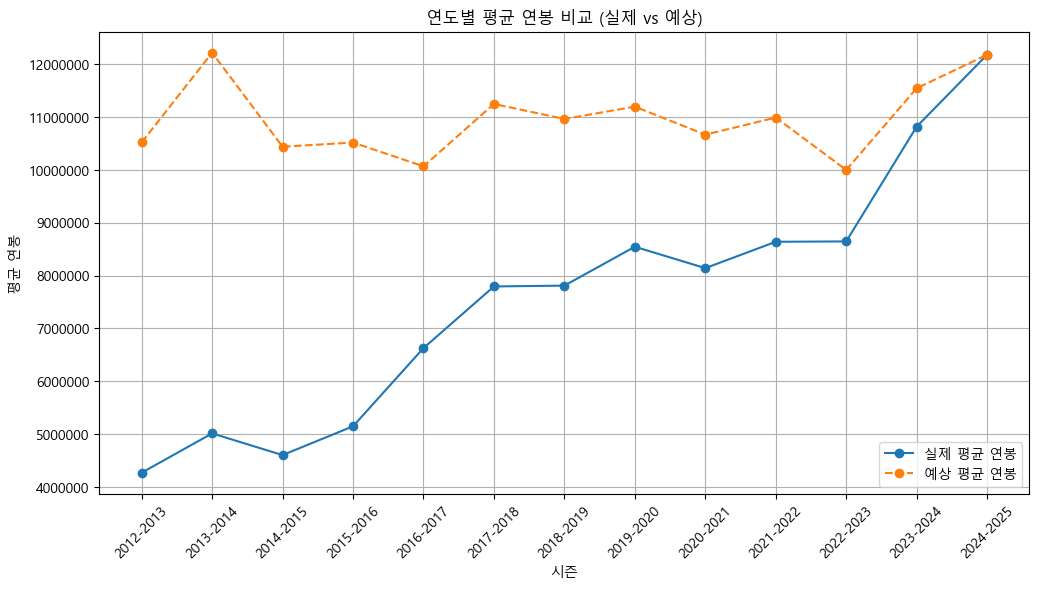

In [363]:
# 시즌별 실제 연봉과 예상 연봉 평균
yearly_avg_salary = final_data.groupby('SEASON')[['SALARY', 'ADJUSTED_SALARY_FOR_CAP']].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_salary.index, yearly_avg_salary['SALARY'], marker='o', label='실제 평균 연봉')
plt.plot(yearly_avg_salary.index, yearly_avg_salary['ADJUSTED_SALARY_FOR_CAP'], marker='o', linestyle='--', label='예상 평균 연봉')
plt.title("연도별 평균 연봉 비교 (실제 vs 예상)")
plt.xlabel("시즌")
plt.ylabel("평균 연봉")
plt.legend()
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### 상관관계 히트맵 시각화
- 예상 연봉(ASFC)와 경기당 평균 득점(PTS) 등이 높은 상관관계를 보인다.

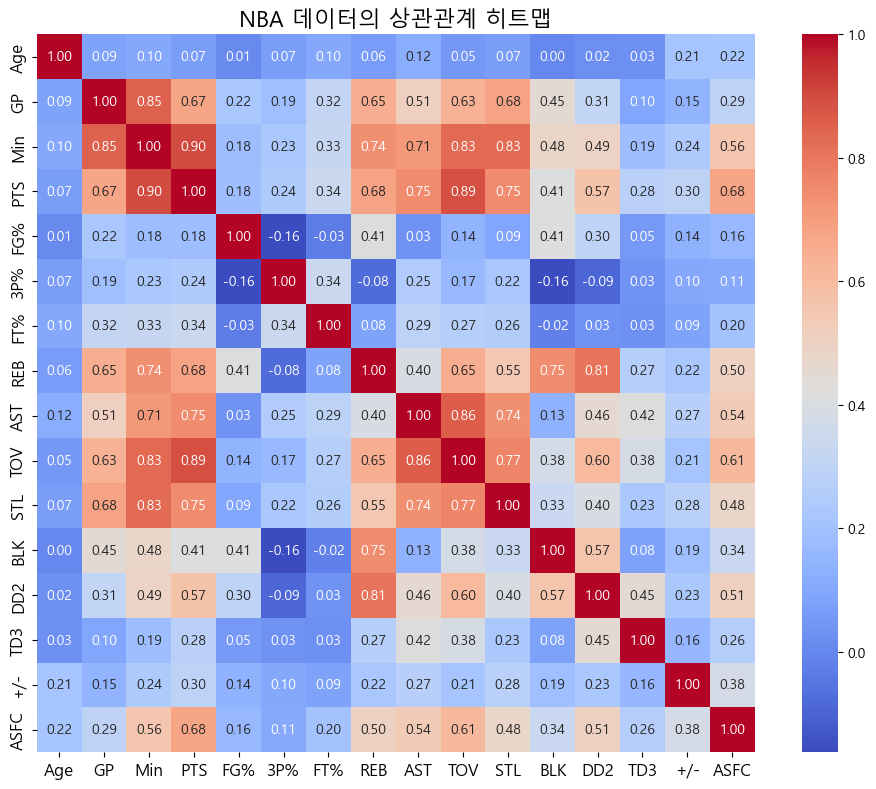

In [364]:
# 주요 연속형 변수 추출
correlation_data = final_data.iloc[:, 1:16]
correlation_data['ASFC'] = final_data[['ADJUSTED_SALARY_FOR_CAP']] # 너무 길어 약어로 변경
 
# 상관계수 계산
correlation_matrix = correlation_data.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("NBA 데이터의 상관관계 히트맵", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### 최근 시즌 추정 연봉과 경기당 득점률 관계 시각화

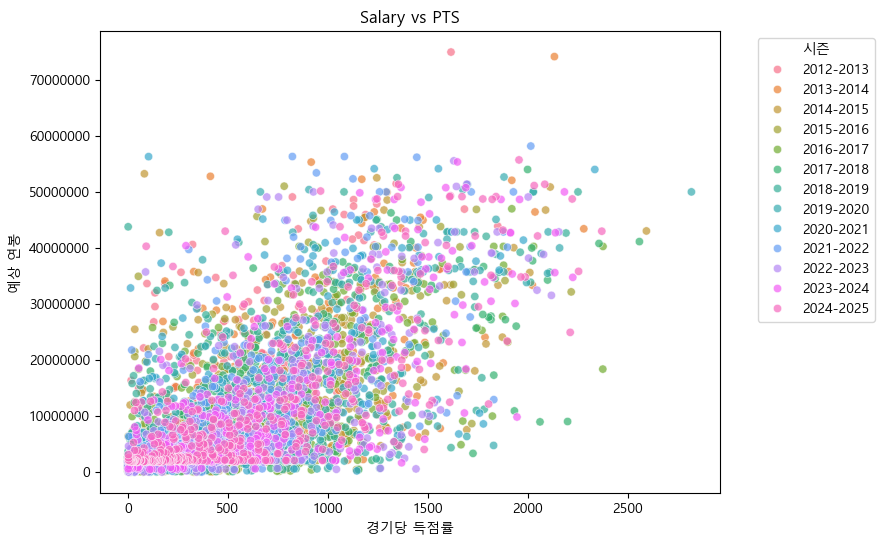

In [367]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_data, x='PTS', y='ADJUSTED_SALARY_FOR_CAP', hue='SEASON', alpha=0.7)
plt.title(f"Salary vs PTS")
plt.xlabel('경기당 득점률')
plt.ylabel("예상 연봉")
plt.ticklabel_format(axis='y',useOffset=False, style='plain')     
plt.legend(title="시즌", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 최근 시즌 추정 연봉과 효율 관계 시각화

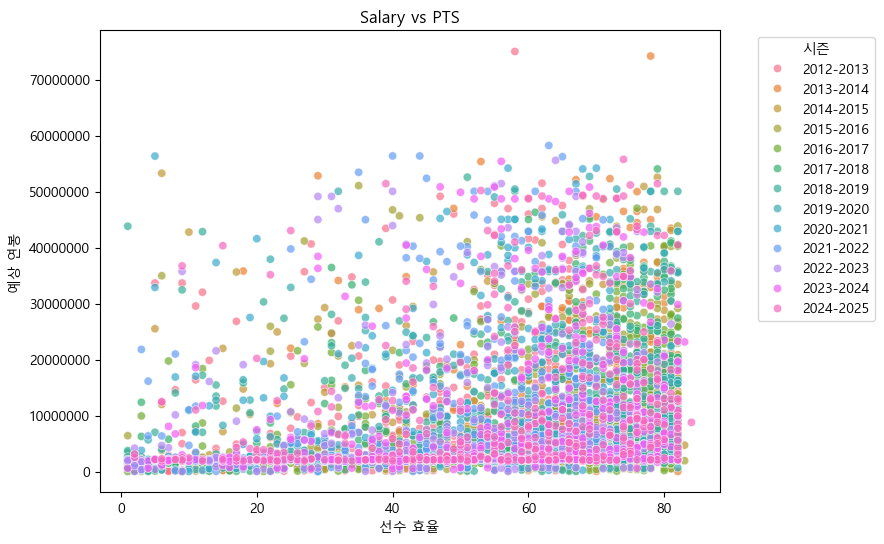

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_data, x='GP', y='ADJUSTED_SALARY_FOR_CAP', hue='SEASON', alpha=0.7)
plt.title(f"Salary vs PTS")
plt.xlabel('선수 효율')
plt.ylabel("예상 연봉")
plt.ticklabel_format(axis='y',useOffset=False, style='plain')     
plt.legend(title="시즌", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 다양한 모델로 연봉 예측 학습

In [ ]:
# 독립 변수
X = final_data.drop(columns=['Player', 'SEASON', 'SALARY', 'ADJUSTED_SALARY_FOR_CAP'])
print(X)

# 종속 변수
y = final_data[['ADJUSTED_SALARY_FOR_CAP']]

      Age  GP     Min   PTS   FG%   3P%    FT%  REB  AST  TOV  STL  BLK  DD2  \
0      23  66  2546.3  1850  49.6  38.7   86.0  527  231  248   88   77   18   
1      27  62  2326.2  1683  53.1  36.2   77.1  492  387  213  115   50   23   
2      33  58  2232.2  1616  43.0  30.3   84.5  313  264  204   69   18    3   
3      23  66  2331.3  1558  45.7  31.6   82.3  301  362  239  112   21    7   
4      23  55  2145.5  1432  44.8  37.2   82.4  734  111  128   47   28   48   
...   ...  ..     ...   ...   ...   ...    ...  ...  ...  ...  ...  ...  ...   
5332   37   9    47.2     8  30.0   0.0  100.0    4    8    5    5    1    0   
5333   27   8    37.3     6  20.0  28.6    0.0    2    0    2    0    2    0   
5334   23   8    23.1     4  16.7   0.0  100.0    5    1    2    2    2    0   
5335   26   2    14.8     4  50.0   0.0    0.0    1    3    1    0    0    0   
5336   19   2    24.0     3  20.0   0.0   50.0    4    3    0    0    1    0   

      TD3  +/-  
0       0  368  
1    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10, min_samples_leaf=4, min_samples_split=2)),
    ('Support Vector Regressor', SVR(kernel='linear', C=1.0, epsilon=0.1)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)),
    ('K-Nearest Neighbors Regressor', KNeighborsRegressor(n_neighbors=5)),
    ('XGBoost Regressor', XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
]

results = []
for name, model in models:
    model.fit(X_train_scaled, y_train.values.ravel())
    y_pred = model.predict(X_test_scaled)
    mse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, r2))
    
    
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R2']).sort_values(by='MSE')
results_df

,Model,MSE,R2
7,XGBoost Regressor,6.458992e+06,0.692210
3,Random Forest Regressor,6.559119e+06,0.682594
5,Gradient Boosting Regressor,6.567451e+06,0.681787
1,Ridge Regression,7.456100e+06,0.589845
0,Linear Regression,7.456225e+06,0.589831
6,K-Nearest Neighbors Regressor,7.569986e+06,0.577220
2,Decision Tree Regressor,9.574299e+06,0.323701
4,Support Vector Regressor,1.264984e+07,-0.180578


### 각 모델의 MSE와 R²를 시각화

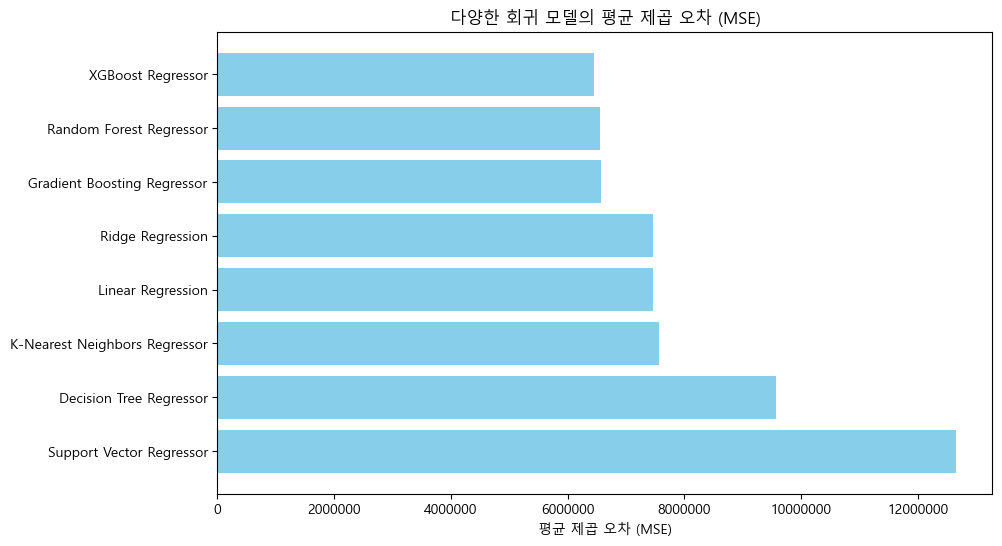

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


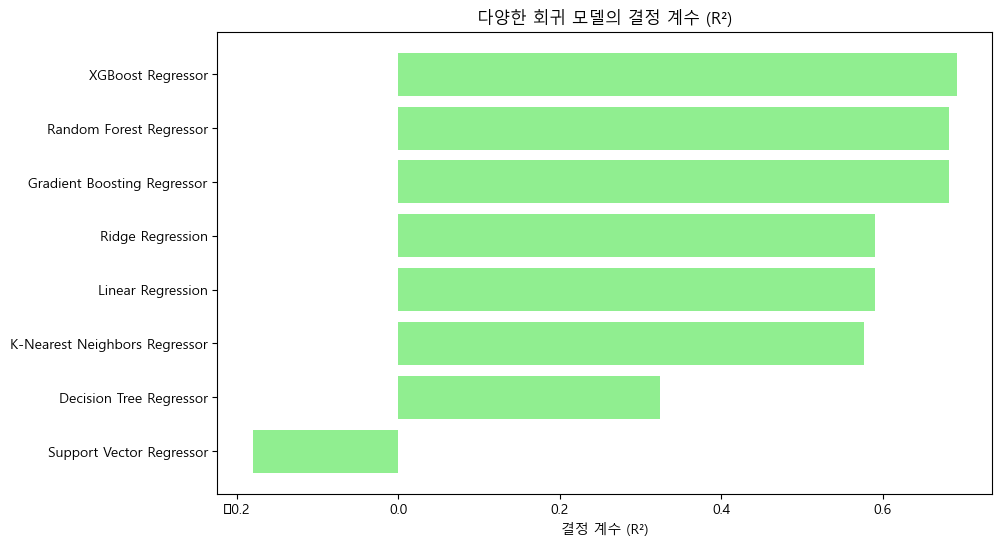

In [ ]:
# MSE 그래프
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['MSE'], color='skyblue')
plt.xlabel('평균 제곱 오차 (MSE)')
plt.title('다양한 회귀 모델의 평균 제곱 오차 (MSE)')
plt.ticklabel_format(axis='x', useOffset=False, style='plain')
plt.gca().invert_yaxis()
plt.show()

# R² 그래프
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['R2'], color='lightgreen')
plt.xlabel('결정 계수 (R²)')
plt.title('다양한 회귀 모델의 결정 계수 (R²)')
plt.gca().invert_yaxis()
plt.show()


### 랜덤 포레스트를 이용해 특성 중요도 시각화

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


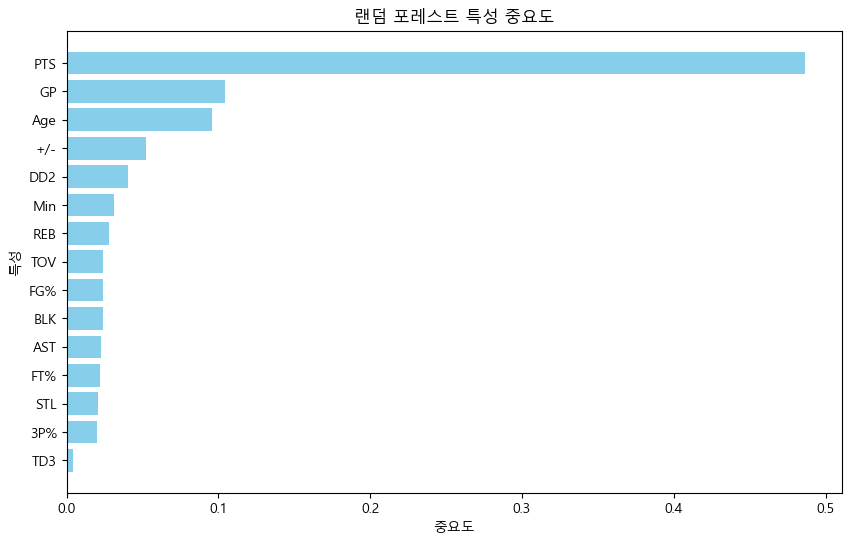

In [ ]:
# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)  # 이미 제공된 데이터로 학습

# 특성 중요도 추출
feature_importances = rf_model.feature_importances_
features = X.columns  # 특성 이름

# 데이터프레임으로 정렬
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('랜덤 포레스트 특성 중요도')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 보기 위해 축 반전
plt.show()

### 실제 연봉과 예측 연봉 비교 시각화

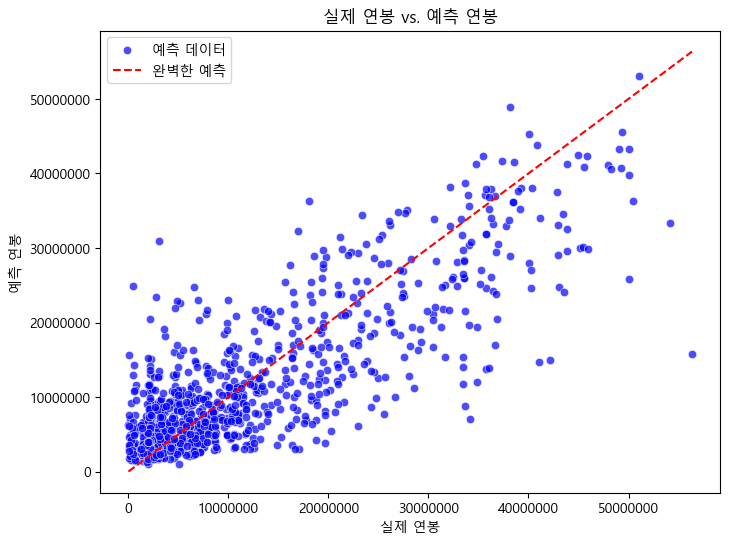

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 실제 값과 예측 값을 비교하기 위해 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Actual': y_test.values.ravel(),  # 실제 연봉 값
    'Predicted': y_pred  # 모델이 예측한 연봉 값
})

# 비교 시각화: 산점도
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=comparison_df['Actual'], 
    y=comparison_df['Predicted'], 
    alpha=0.7, 
    color='blue', 
    label='예측 데이터'
)
# 완벽한 예측을 나타내는 대각선 추가
plt.plot(
    [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
    [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
    'r--',
    label='완벽한 예측'
)
plt.title('실제 연봉 vs. 예측 연봉')  # 제목 추가
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.ticklabel_format(axis='x',useOffset=False, style='plain')
plt.xlabel('실제 연봉')  # x축 라벨
plt.ylabel('예측 연봉')  # y축 라벨
plt.legend()  # 범례 표시
plt.show()  # 그래프 출력

In [ ]:
final_data[final_data['Player'] == 'Pascal Siakam']


,Player,Age,GP,Min,PTS,FG%,3P%,FT%,REB,AST,TOV,STL,BLK,DD2,TD3,+/-,SALARY,ADJUSTED_SALARY_FOR_CAP,SEASON
2286,Pascal Siakam,23,55,859.1,229,50.2,14.3,68.8,185,17,33,26,45,0,0,-52,1544951,2229501,2017-2018
2580,Pascal Siakam,24,81,1679.2,589,50.8,22.0,62.1,364,159,67,62,42,0,0,303,1544951,2168746,2018-2019
2851,Pascal Siakam,25,80,2547.6,1354,54.9,36.9,78.5,549,248,154,73,52,18,0,593,2351839,3081482,2019-2020
3236,Pascal Siakam,26,60,2110.2,1371,45.3,35.9,79.2,439,207,148,61,53,12,0,398,30559200,40040000,2020-2021
3677,Pascal Siakam,27,56,2006.0,1196,45.5,29.7,82.7,405,250,130,64,37,13,1,130,33003936,41983764,2021-2022
4080,Pascal Siakam,28,68,2577.9,1551,49.4,34.4,74.9,580,360,181,85,42,30,2,257,35448672,40994380,2022-2023
4527,Pascal Siakam,29,71,2652.0,1720,48.0,32.4,77.4,556,415,169,65,36,24,2,123,37893408,40438487,2023-2024
4945,Pascal Siakam,30,80,2657.9,1737,53.6,34.6,73.2,565,342,141,63,25,15,1,113,42176000,42176000,2024-2025


In [ ]:
# Combine actual and predicted salary data into a single DataFrame

salary_comparison_df = final_data.iloc[y_test.index]
salary_comparison_df['Actual Salary'] = y_test.values.ravel()
salary_comparison_df['Predicted Salary'] = y_pred
# Adding a column to show the difference
salary_comparison_df['Difference'] = salary_comparison_df['Actual Salary'] - salary_comparison_df['Predicted Salary']

# Sort by the absolute value of the difference for better insights
salary_comparison_df = salary_comparison_df.reindex(y_test.index)
salary_comparison_df_sorted = salary_comparison_df.sort_values(by='Difference', ascending=True)

# Display the sorted DataFrame to the user
salary_comparison_df_sorted


C:\Users\User\AppData\Local\Temp\ipykernel_19700\1809422110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_comparison_df['Actual Salary'] = y_test.values.ravel()
C:\Users\User\AppData\Local\Temp\ipykernel_19700\1809422110.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_comparison_df['Predicted Salary'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_19700\1809422110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Player,Age,GP,Min,PTS,FG%,3P%,FT%,REB,AST,...,BLK,DD2,TD3,+/-,SALARY,ADJUSTED_SALARY_FOR_CAP,SEASON,Actual Salary,Predicted Salary,Difference
2851,Pascal Siakam,25,80,2547.6,1354,54.9,36.9,78.5,549,248,...,52,18,0,593,2351839,3081482,2019-2020,3081482,30946980.0,-27865498.0
2063,Derrick Rose,28,64,2081.8,1154,47.1,21.7,87.4,246,283,...,17,2,0,-165,290951,419868,2017-2018,419868,24862274.0,-24442406.0
1433,Andrea Bargnani,29,29,785.3,430,45.4,36.6,81.3,127,46,...,27,2,0,-270,1362897,2784203,2015-2016,2784203,23366742.0,-20582539.0
3773,Andre Drummond,27,46,1241.6,687,49.3,0.0,60.0,551,94,...,49,28,0,-105,1669178,2123333,2021-2022,2123333,20405752.0,-18282419.0
800,Dirk Nowitzki,36,80,2628.1,1735,49.7,39.8,89.9,498,216,...,45,6,0,322,7974482,18082152,2014-2015,18082152,36315320.0,-18233168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,Brook Lopez,24,5,136.0,96,49.4,0.0,62.5,18,6,...,4,0,0,-27,13668750,33674992,2012-2013,33674992,8749797.0,24925195.0
2596,Paul Millsap,33,38,1143.5,555,46.4,34.5,69.6,245,105,...,44,2,0,101,29230769,41033091,2018-2019,41033091,14669964.0,26363127.0
733,Andrew Bogut,28,32,785.7,186,45.1,100.0,50.0,245,67,...,55,1,0,37,14000000,34117827,2013-2014,34117827,7123884.5,26993942.5
4932,Anthony Edwards,22,79,2770.4,2049,46.1,35.7,83.6,430,405,...,42,9,0,432,42176400,42176400,2024-2025,42176400,14984844.0,27191556.0
